# 0.0 Imports

In [23]:
# data manipulation
import pandas as pd
import numpy  as np

# data visutalization
import matplotlib.pyplot as plt
import seaborn           as sns

# stats
import scipy as ss

#encoding
from imblearn.combine      import SMOTETomek
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder

# feature selection
from boruta                    import BorutaPy
from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D

# modeling
from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh

from sklearn.ensemble    import RandomForestClassifier
from sklearn.ensemble    import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn             import base
from sklearn             import linear_model as lm
from sklearn             import neighbors    as nh
from xgboost             import XGBClassifier

# model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#metrics
import scikitplot as skplt
from   sklearn.metrics  import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics       import roc_auc_score

#display
from IPython.display       import Image
from IPython.core.display  import HTML

import warnings
warnings.filterwarnings( 'ignore' )

# 0.1 Helper Functions

In [47]:
def precision_at_k(data, yhat_proba, k=20):
    data['score'] = yhat_proba[:,1].tolist()
    data = data.sort_values('score',ascending=False)    
    data = data.reset_index(drop=True)
    data['ranking'] = data.index+1
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
    
    return (data.loc[k, 'precision_at_k'])

In [48]:
def recall_at_k(data, yhat_proba, k=10):
    data['score'] = yhat_proba[:,1].tolist()
    data = data.sort_values('score',ascending=False)    
    data = data.reset_index(drop=True)
    data['ranking'] = data.index+1
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
    
    return (data.loc[k, 'recall_at_k'])

In [ ]:
def cross_validation(num_folds,modelName, model, x_train, y_train):
    #models_performance
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=0)
    
    precision_list = []
    recall_list = []
     
    for train_cv, val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)
        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        precision = round(precision_at_k(x_val_fold, yhat_model, 20000),3)
        precision_list.append(precision)
        
        recall= round(recall_at_k(x_val_fold, yhat_model, 20000),3)              
        recall_list.append(recall)
        
    return pd.DataFrame( {'Model Name': modelName,
                          'Precision_at_k': np.round(np.mean(precision_list),3).astype(str) + ' +/- ' + np.round(np.std(precision_list),3).astype(str),
                          'Recall_at_k': np.round(np.mean(recall_list),3).astype(str) + ' +/- ' + np.round(np.std(recall_list),3).astype(str) }, index=[0] )


# 0.2 Load Dataset

In [24]:
df_raw = pd.read_csv('pa004Data.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 Data Description

## 1.1 Rename Columns

In [25]:
df_raw = df_raw.rename(columns=str.lower)
df_raw.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.2 Data Dimensions

## Split Data into training and test 

In [26]:
X_data = df_raw.drop(['response'], axis = 1)
y_data = df_raw['response'].copy()

x_data, x_test, y_data, y_test = ms.train_test_split(X_data,y_data,test_size=0.1)

df = pd.concat([x_data, y_data], axis = 1)

## 1.3 Data Types

In [27]:
df.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [28]:
df.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [29]:
df.duplicated().sum()

0

In [30]:
df1= df.copy()

In [31]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.5. Data Descriptive

In [32]:
num_attributes = df1[['age', 'region_code', 'annual_premium', 'policy_sales_channel', 'vintage' ]]
cat_attributes = df1[['gender', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

### 1.5.1. Numerical Attributes

In [33]:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.821530,36.0,15.511959,0.673196,-0.564893
1,region_code,0.0,52.0,52.0,26.383235,28.0,13.228449,-0.114703,-0.868352
2,annual_premium,2630.0,540165.0,537535.0,30555.419950,31658.0,17217.321900,1.808523,35.409417
3,policy_sales_channel,1.0,163.0,162.0,112.083012,135.0,54.184263,-0.902080,-0.966751
4,vintage,10.0,299.0,289.0,154.312605,154.0,83.671296,0.003192,-1.201047


In [34]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender                2
driving_license       2
vehicle_age           3
vehicle_damage        2
previously_insured    2
response              2
dtype: int64

# 2.0 Feature Engineering

In [35]:
df1['vehicle_age'] = df1['vehicle_age'].apply(lambda x: 'below_1_year' if x == '< 1 Year' else 'between_1_2_year' if x == '1-2 Year' else 'over_2_years')
df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
283691,283692,Male,41,1,28.0,1,between_1_2_year,0,24082.0,124.0,258,0
18394,18395,Female,23,1,8.0,1,below_1_year,0,2630.0,159.0,24,0
263923,263924,Female,24,1,28.0,1,between_1_2_year,0,43540.0,124.0,79,0
364281,364282,Male,52,1,7.0,1,between_1_2_year,0,44620.0,26.0,215,0
133773,133774,Female,24,1,11.0,1,below_1_year,0,25054.0,152.0,251,0


## 3.0 Data Filtering

# 4.0. Exploratoria Data Analysis

## 4.1. Univariate Analysis

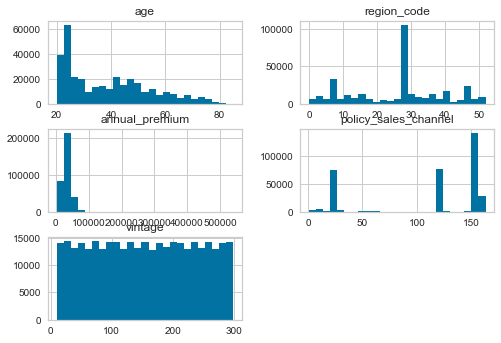

In [88]:
num_attributes.hist( bins=25 );

<AxesSubplot:xlabel='response', ylabel='count'>

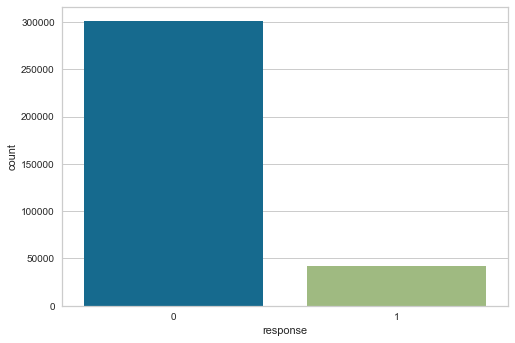

In [89]:
sns.countplot( df1.response )

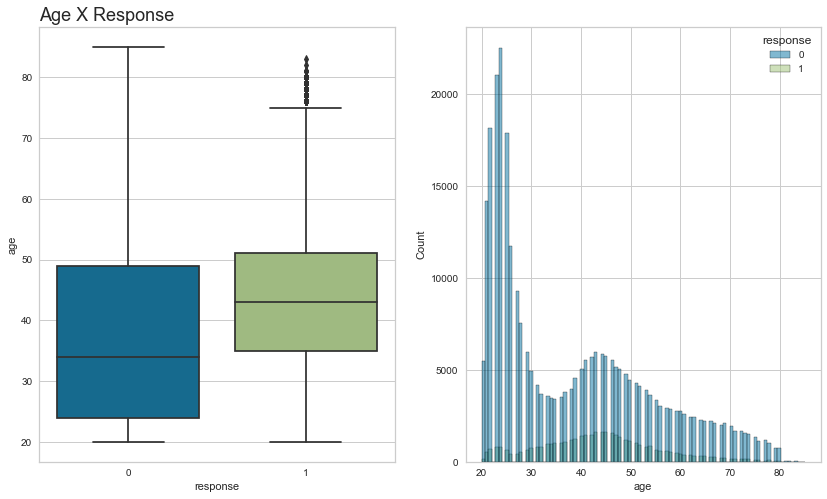

In [90]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.boxplot(data=df1, x='response', y='age' )
plt.title('Age X Response', loc='left', fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(df1, x='age', hue='response')
plt.show()

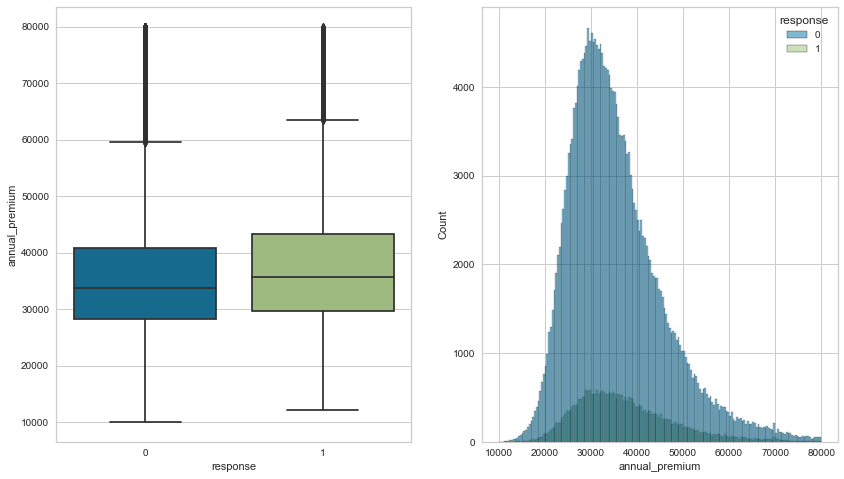

In [91]:
plt.figure(figsize=(14, 8))
aux = df1[(df1.annual_premium > 10000) & (df1.annual_premium < 80000)]

plt.subplot(1, 2, 1)
sns.boxplot(data=aux, x='response', y='annual_premium' )

plt.subplot(1, 2, 2)
sns.histplot(x='annual_premium', data=aux, hue='response')
plt.show()

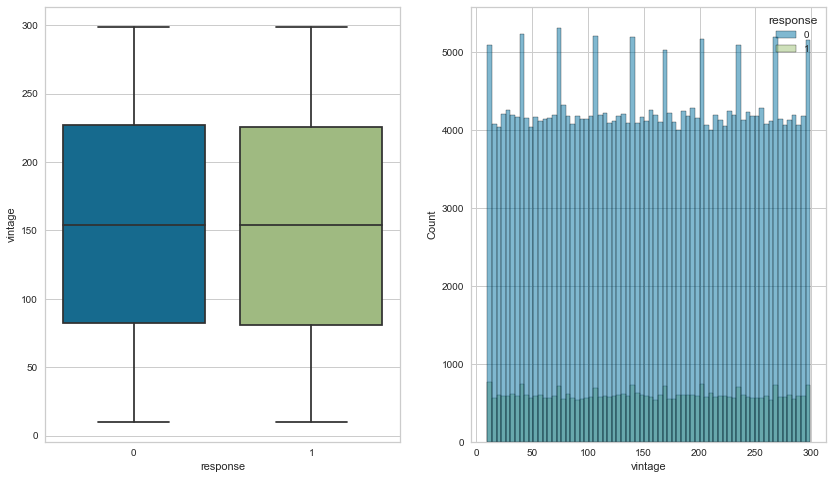

In [92]:
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x= 'response', y= 'vintage', data=df1 )

plt.subplot(1, 2, 2)
sns.histplot(x='vintage', data=df1, hue='response')
plt.show()

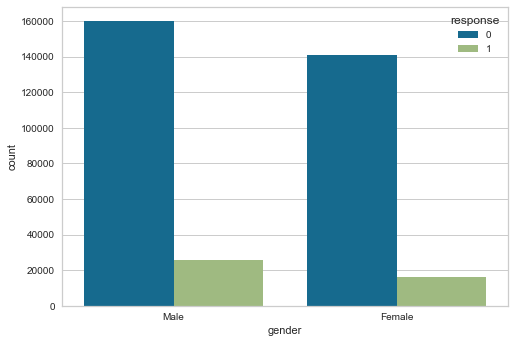

In [93]:
sns.countplot(data=df1, x='gender', hue='response')
plt.show()

In [94]:
aux = df1.groupby('response').driving_license.sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,300214,0.877149
1,1,42047,0.122851


In [95]:
pd.crosstab(df1['driving_license'], df1['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
driving_license,,
0,0.948440,0.051560
1,0.877149,0.122851


<AxesSubplot:xlabel='region_code', ylabel='id'>

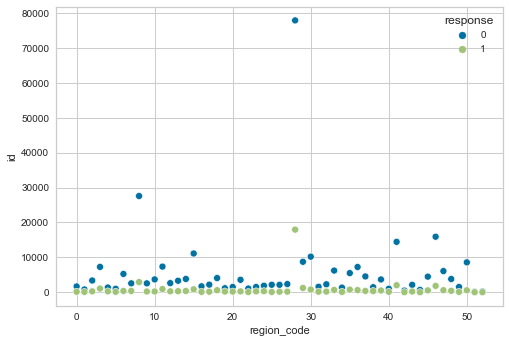

In [96]:
aux0 = df1.groupby(['region_code', 'response']).id.count().reset_index()
sns.scatterplot(x='region_code', y = 'id', hue = 'response', data=aux0)

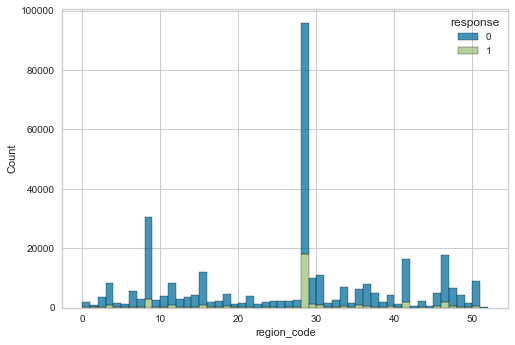

In [97]:
sns.histplot(data=df1, x='region_code', hue='response', multiple='stack', binwidth=1);

In [98]:
pd.crosstab(df1['previously_insured'], df1['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774377,0.225623
1,0.999071,0.000929


In [99]:
df1[['vehicle_age', 'response']].value_counts(normalize=True).sort_index().reset_index()

,vehicle_age,response,0
0,below_1_year,0,0.413460
1,below_1_year,1,0.018840
2,between_1_2_year,0,0.434134
3,between_1_2_year,1,0.091552
4,over_2_years,0,0.029709
5,over_2_years,1,0.012306


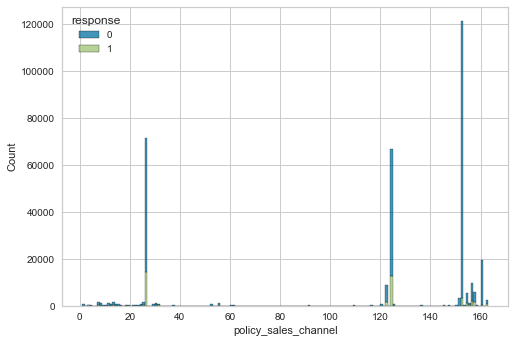

In [100]:
sns.histplot(data=df1, x='policy_sales_channel', hue='response', multiple='stack', binwidth=1);
#sns.histplot(x='policy_sales_channel', data=df1, hue='response')

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

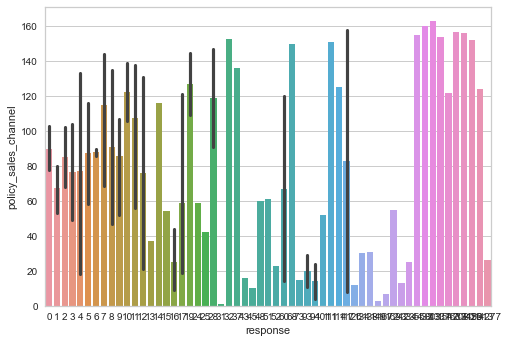

In [101]:
#fazer stack 
aux = df1.groupby('policy_sales_channel').response.sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)

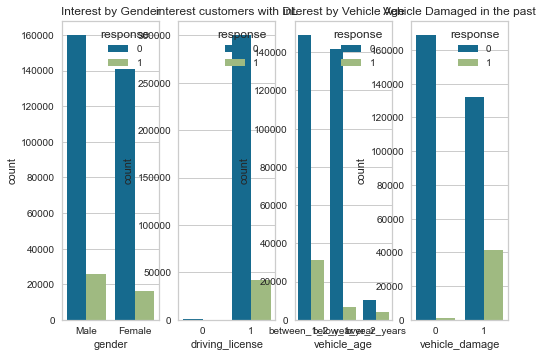

In [102]:
plt.subplot(1, 4, 1)
sns.countplot(data=df1, x='gender', hue='response')
plt.title('Interest by Gender');

plt.subplot(1, 4, 2)
sns.countplot(data=df1, x='driving_license', hue='response')
plt.title('interest customers with DL');

plt.subplot(1, 4, 3)
sns.countplot(data=df1, x='vehicle_age', hue='response')
plt.title('interest by Vehicle Age');

plt.subplot(1, 4, 4)
sns.countplot(data=df1, x='vehicle_damage', hue='response')
plt.title('Vehicle Damaged in the past');

In [103]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

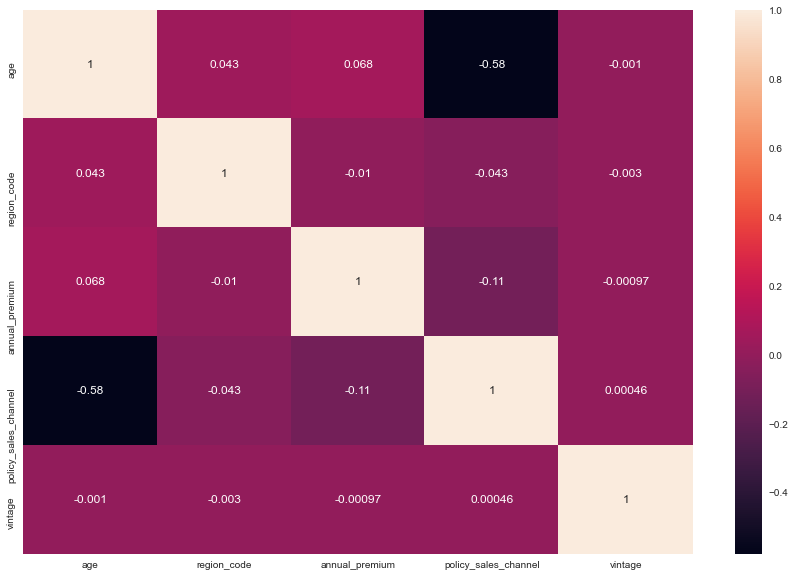

In [104]:
correlation = num_attributes.corr(method ='pearson')
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True)
plt.show()

<AxesSubplot:xlabel='gender', ylabel='Count'>

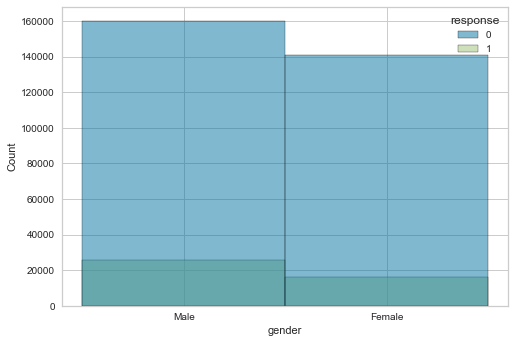

In [105]:
sns.histplot(df1, x="gender", hue="response")

# 5.0. Data Preparation

In [17]:
df2 = df1.copy()

In [18]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
351305,351306,Male,59,1,28.0,1,between_1_2_year,0,42013.0,124.0,232,0
361877,361878,Male,67,1,50.0,0,between_1_2_year,1,22567.0,26.0,263,0
202248,202249,Female,28,1,6.0,1,below_1_year,0,14435.0,152.0,44,0
270246,270247,Female,44,1,28.0,0,between_1_2_year,1,45232.0,26.0,193,1
27364,27365,Male,48,1,28.0,1,between_1_2_year,0,39926.0,122.0,261,0


In [39]:
X = df2.drop( 'response', axis=1 )
y = df2['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [40]:
df2.shape

(342998, 12)

In [41]:
df5.shape

(274398, 12)

## 5.1. Standardization

In [43]:
# age é mais poason
#annual é tipo normal, sem os outlairs 
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
#pickle.dump( ss, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [44]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump( mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In [45]:
#driving license,#previously_insured  - nao precisa encodar pq ele ja é naturalmente encodada como label encoder, sendo o 1 com mais peso que o 0

# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
#pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump( fe_policy_sales_channel, open( '../src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) 

### 5.4. Validation Preparation

In [49]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

KeyError: "None of [Index(['vehicle_age'], dtype='object')] are in the [columns]"

# 6.0. Feature Selection

## 6.2. Feature Importance

In [115]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.271717
0                annual_premium    0.242404
0                           age    0.167767
0                   region_code    0.105841
0                vehicle_damage    0.066410
0          policy_sales_channel    0.059912
0            previously_insured    0.057723
0      vehicle_age_below_1_year    0.013699
0  vehicle_age_between_1_2_year    0.006427
0                        gender    0.005023
0      vehicle_age_over_2_years    0.002559
0               driving_license    0.000519


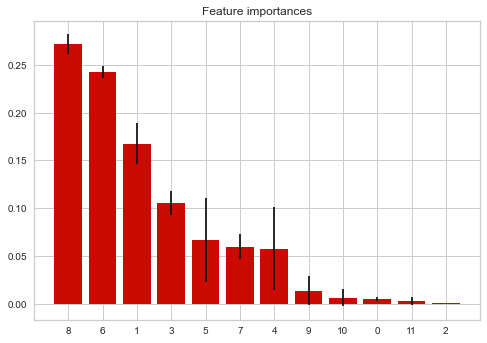

In [116]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning Models

In [50]:
cols_selected = [ 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

## 7.1 KNN Classifier

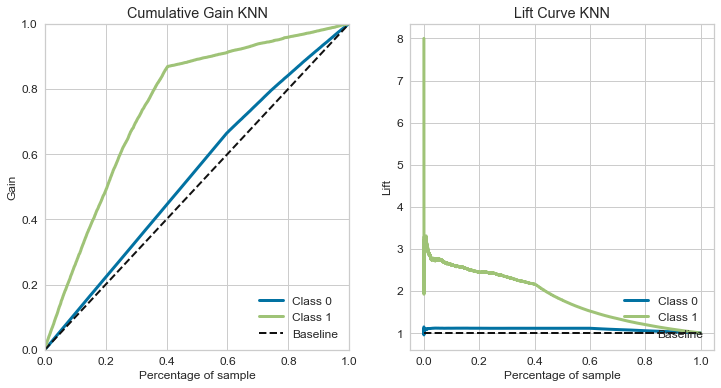

In [52]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7, n_jobs =-1 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axs[0],title='Cumulative Gain KNN');

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn,ax=axs[1],title='Lift Curve KNN');

In [53]:
#criar um score que gere a maior probabilidade de propensao de compra 
#lista ordenada 

## 7.2 Logistic Regression model 

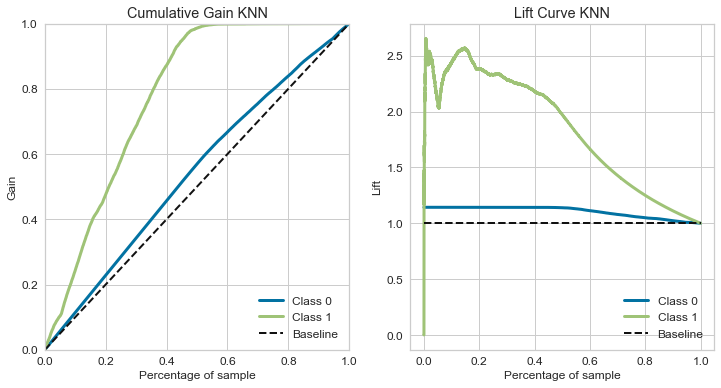

In [54]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axs[0],title='Cumulative Gain KNN');

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr,ax=axs[1],title='Lift Curve KNN');

## 7.3 Random Forest Model 

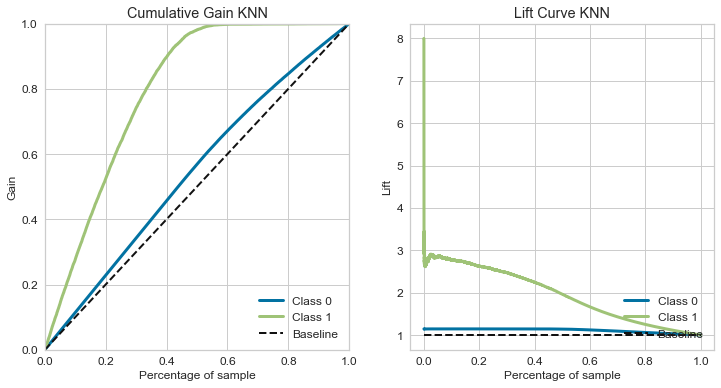

In [55]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_val )

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax=axs[0],title='Cumulative Gain KNN');

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf,ax=axs[1],title='Lift Curve KNN');

## 7.4 XGBoost Classifier model

<AxesSubplot:title={'center':'Lift Curve xgb'}, xlabel='Percentage of sample', ylabel='Lift'>

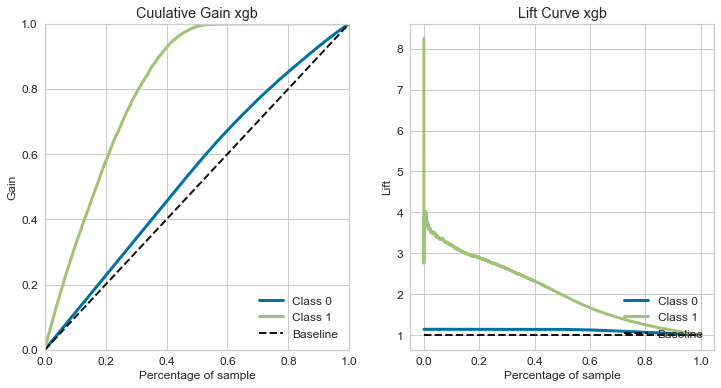

In [132]:
xgb_model = XGBClassifier(objective ='binary:logistic', eval_metric = 'error')

model_xgb = xgb_model.fit(x_train,y_train)

yhat_xgb = model_xgb.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax=axs[0],title='Cuulative Gain xgb');
skplt.metrics.plot_lift_curve(y_val, yhat_xgb,ax=axs[1],title='Lift Curve xgb')

## 7.5 Naive Bayes Classifier model

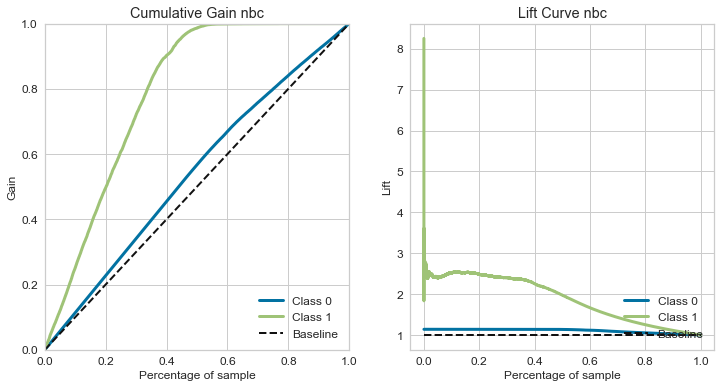

In [133]:
nbc_model = GaussianNB()

model_nbc = nbc_model.fit(x_train,y_train)

yhat_nbc = model_nbc.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_nbc, ax=axs[0],title='Cumulative Gain nbc');
skplt.metrics.plot_lift_curve(y_val, yhat_nbc,ax=axs[1],title='Lift Curve nbc');

## 6.7 Final Models result 

In [141]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

precision_knn = round(precision_at_k(df8, yhat_knn, 20000),3)
recall_knn = round(recall_at_k(df8, yhat_knn, 20000),3)

precision_xgb = round(precision_at_k(x_validation, yhat_xgb,20000),3)
recall_xgb= round(recall_at_k(x_validation, yhat_xgb, 20000),3)

precision_lr = round(precision_at_k(x_validation, yhat_lr,20000),3)
recall_lr= round(recall_at_k(x_validation, yhat_lr, 20000),3)

precision_rf = round(precision_at_k(x_validation, yhat_rf,20000),3)
recall_rf= round(recall_at_k(x_validation, yhat_rf, 20000),3)

precision_nbc = round(precision_at_k(x_validation, yhat_nbc,20000),3)
recall_nbc= round(recall_at_k(x_validation, yhat_nbc, 20000),3)


models_performance = pd.DataFrame({'Model':['KNN Model'], "Precision_at_k": [precision_knn], "Recall_at_k": [recall_knn]})
models_performance = models_performance.append(pd.Series(['XGBoost Classifier', precision_xgb, recall_xgb], index=models_performance.columns), ignore_index=True)
models_performance = models_performance.append(pd.Series(['Logistic Regression Model', precision_lr, recall_lr], index=models_performance.columns), ignore_index=True)
models_performance = models_performance.append(pd.Series(['Random Forest Model', precision_rf, recall_rf], index=models_performance.columns), ignore_index=True)
models_performance = models_performance.append(pd.Series(['Naive Bayes Classifier', precision_nbc, recall_nbc], index=models_performance.columns), ignore_index=True)

models_performance.sort_values('Precision_at_k', ascending=False).reset_index().drop('index', axis=1)

,Model,Precision_at_k,Recall_at_k
0,XGBoost Classifier,0.330,0.716
1,Random Forest Model,0.308,0.667
2,KNN Model,0.293,0.634
3,Naive Bayes Classifier,0.293,0.635
4,Logistic Regression Model,0.284,0.616


## 6.8 Cross Validation

In [183]:
xgb_cv = cross_validation(5 , 'XGBoost Classifier CV', xgb_model, x_train, y_train)
lr_cv = cross_validation(5 , 'Logistic Regression CV', lr_model, x_train, y_train)
knn_cv = cross_validation(5 , 'K Neighbors Classifier CV', knn_model, x_train, y_train)
rf_cv = cross_validation(5 , 'Random Forest Classifier CV', rf, x_train, y_train)
nbc_cv = cross_validation(5 , 'Naive Bayes Classifier CV', nbc_model, x_train, y_train)

modelling_result_cv = pd.concat( [xgb_cv, lr_cv, knn_cv, rf_cv, nbc_cv] )
modelling_result_cv.sort_values('Precision_at_k', ascending=False)

,Model Name,Precision_at_k,Recall_at_k
0,XGBoost Classifier CV,0.309 +/- 0.001,0.825 +/- 0.003
0,Random Forest Classifier CV,0.294 +/- 0.001,0.784 +/- 0.002
0,Naive Bayes Classifier CV,0.291 +/- 0.001,0.776 +/- 0.002
0,Logistic Regression CV,0.276 +/- 0.001,0.736 +/- 0.004
0,K Neighbors Classifier CV,0.275 +/- 0.001,0.734 +/- 0.001


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search 

In [56]:
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [57]:
clf_xgb = XGBClassifier(objective = 'binary:logistic', eval_metric='error')

param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

#numFolds = 5
#kfold_5 = cross_validation.KFold(n = len(X), shuffle = True, n_folds = numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 5, #kfold_5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', #'accuracy'
                         n_jobs = -1,
                         return_train_score=True,
                         random_state=0).fit(x_train, y_train)

best_score = clf.best_score_
best_params = clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))


[15:00:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.8521049531005641
Best params: 
colsample_bytree: 0.5284144232791548
learning_rate: 0.061406286823909015
max_depth: 6
min_child_weight: 1
n_estimators: 905
subsample: 0.8742930953718278


## 8.2 Applying hiperparameters XGB model 

In [62]:
xgb_model_tunned = XGBClassifier( objective='binary:logistic', 
                                  eval_metric='error',
                                  n_estimators = 905,
                                  learning_rate = 0.061,
                                  subsample = 0.874,
                                  max_depth = 6,
                                  colsample_bytree = 0.528,
                                  min_child_weight = 1,
                                  random_state=0, n_jobs = -1 )

xgb_model_tunned_cv = cross_validation(5 , 'XGBoost Classifier Tunned CV', xgb_model_tunned, x_train, y_train)

[15:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [63]:
xgb_model_tunned_cv_performance

,Model Name,Precision_at_k,Recall_at_k
0,XGBoost Classifier Tunned CV,0.296 +/- 0.002,0.88 +/- 0.007


# Applying model test 

In [ ]:
#agregar train com validation

## Test preparation 

In [51]:
x_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
336988,336989,Male,22,1,17.0,1,< 1 Year,No,29882.0,152.0,174
149458,149459,Female,21,1,39.0,1,< 1 Year,No,34801.0,152.0,212
43469,43470,Male,53,1,32.0,0,1-2 Year,Yes,36489.0,26.0,163
378197,378198,Male,48,1,8.0,0,> 2 Years,Yes,53320.0,124.0,59
306688,306689,Male,45,1,38.0,0,1-2 Year,Yes,2630.0,124.0,158


In [52]:
x_test.shape

(38111, 11)

In [53]:
#x_test.loc[:, 'gender'] =  x_test.loc[:, 'gender'].map( target_encode_gender )

x_test['vehicle_damage'] = x_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# age
x_test.loc[:, 'age'] = mms_age.transform( x_test[['age']].values )

# region_code
x_test.loc[:, 'region_code'] = x_test.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
#x_test = pd.get_dummies( x_test, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_test.loc[:, 'annual_premium'] = ss.transform( x_test[['annual_premium']].values )

# policy_sales_channel
x_test.loc[:, 'policy_sales_channel'] = x_test['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_test.loc[:, 'vintage'] = mms_vintage.transform( x_test[['vintage']].values )

# fillna
x_test = x_test.fillna( 0 )

x_test = x_test[cols_selected]

## XGB Classifier model

In [54]:
xgb_model = XGBClassifier( objective='binary:logistic', 
                                  eval_metric='error',
                                  n_estimators = 905,
                                  learning_rate = 0.061,
                                  subsample = 0.874,
                                  max_depth = 6,
                                  colsample_bytree = 0.528,
                                  min_child_weight = 1,
                                  random_state=0, n_jobs = -1 ).fit(x_train,y_train)

yhat_xgb = xgb_model.predict_proba(x_test)

## Model performance

In [55]:
df9 = x_test.copy()
df9['response'] = y_test.copy()

precision_xgb = round(precision_at_k(df9, yhat_xgb,20000),3)
recall_xgb= round(recall_at_k(df9, yhat_xgb, 20000),3)

In [56]:
precision_xgb

0.23

In [57]:
recall_xgb

0.997

In [134]:
yhat_proba_test = xgb_model_tunned.predict_proba(x_test)

<AxesSubplot:title={'center':'Lift Curve lgbm'}, xlabel='Percentage of sample', ylabel='Lift'>

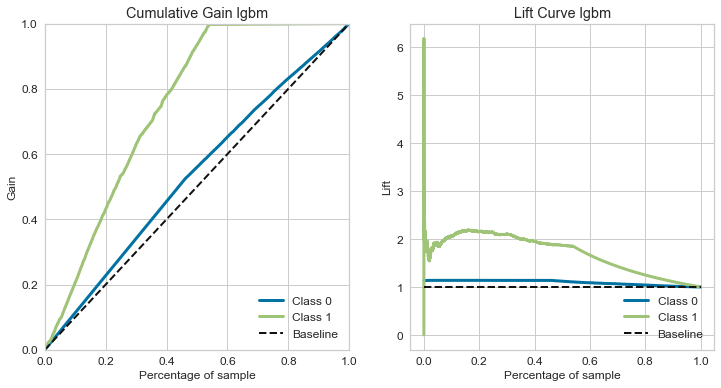

In [135]:
fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_test, ax=axs[0],title='Cumulative Gain lgbm');
skplt.metrics.plot_lift_curve(y_test, yhat_proba_test,ax=axs[1],title='Lift Curve lgbm')